In [1]:
import os, sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

In [2]:
import numpy as np
import pandas as pd
import torch
import random
from peft import get_peft_config, get_peft_model, PrefixTuningConfig, TaskType
from transformers import AutoTokenizer
from datasets import load_dataset, Dataset, concatenate_datasets, DatasetDict
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from src.data.make_dataset import Evaluator
import evaluate

torch.manual_seed(0)
random.seed(0)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

## Datasets

In [3]:
train_df, val_df, test_df = [pd.read_csv(f'../data/interim/{stage}.tsv', sep='\t') for stage in ['train', 'val', 'test']]

In [4]:
train_df = train_df.rename(columns={'reference': 'source', 'translation': 'target'})
val_df = val_df.rename(columns={'reference': 'source', 'translation': 'target'})
test_df = test_df.rename(columns={'reference': 'source', 'translation': 'target'})

In [5]:
dataset = DatasetDict()
dataset['train'] = Dataset.from_pandas(train_df[['source','target']])
dataset['val'] = Dataset.from_pandas(val_df[['source','target']])
dataset['test'] = Dataset.from_pandas(test_df[['source','target']])

In [6]:
for a in dataset['train']:
    print(a)
    break

{'source': 'Couple of bloody coppers!', 'target': 'bunch of goddamn cops!'}


In [7]:
checkpoint = "t5-small"
max_length = 128
virtual_tokens = 8
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [8]:
def preprocess_function(examples):
    model_inputs = tokenizer(examples['source'], max_length=max_length-virtual_tokens, padding='max_length', truncation=True)
    labels = tokenizer(examples['target'], max_length=max_length-virtual_tokens, padding='max_length', truncation=True)
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [9]:
tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)

  0%|          | 0/463 [00:00<?, ?ba/s]

  0%|          | 0/58 [00:00<?, ?ba/s]

  0%|          | 0/58 [00:00<?, ?ba/s]

In [10]:
for a in tokenized_datasets['train']:
    print(a)
    break

{'input_ids': [25185, 13, 1717, 63, 8658, 7, 55, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [7292, 13, 8581, 7812, 29, 7326, 7, 55, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [11]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [12]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(tokenized_datasets['train'], batch_size=batch_size, shuffle=True, collate_fn=data_collator)
val_loader = torch.utils.data.DataLoader(tokenized_datasets['val'], batch_size=batch_size, shuffle=False, collate_fn=data_collator)
test_loader = torch.utils.data.DataLoader(tokenized_datasets['test'], batch_size=batch_size, shuffle=False, collate_fn=data_collator)

In [13]:
for a in train_loader:
    print(a.keys())
    print(a['input_ids'].shape)
    print(a['labels'].shape)
    break

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dict_keys(['input_ids', 'attention_mask', 'labels'])
torch.Size([32, 120])
torch.Size([32, 120])


## Metrics and loss

In [14]:
bleu_score = evaluate.load("bleu")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions, labels = predictions.detach().cpu(), labels.detach().cpu()
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    bleu_results = bleu_score.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])
    # results = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    # results['bleu'] = bleu_results['bleu']
    return {'bleu': bleu_results['bleu']}

### Model

In [15]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [16]:
peft_config = PrefixTuningConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    num_virtual_tokens=virtual_tokens
)

In [17]:
for param in model.parameters():
    param.requires_grad = False

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
model.to(device);

trainable params: 49,152 || all params: 60,555,776 || trainable%: 0.08116814488513863


In [18]:
for batch in train_loader:
    with torch.inference_mode():
        batch = {k: v.to(device) for k, v in batch.items()}
        print([v.shape for k, v in batch.items()])
        model_output = model(**batch)
    print(model_output.loss)
    print(model_output.logits.shape)
    print(compute_metrics((a['input_ids'], a['labels'],)))
    break

[torch.Size([32, 120]), torch.Size([32, 120]), torch.Size([32, 120])]
tensor(15.0858, device='cuda:0')
torch.Size([32, 120, 32128])
{'bleu': 0.2439398727378744}


## Training

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epochs = 5
model.to(device)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [20]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "max_split_size_mb:128"
model_id = "T5-small-prefix-tuning"

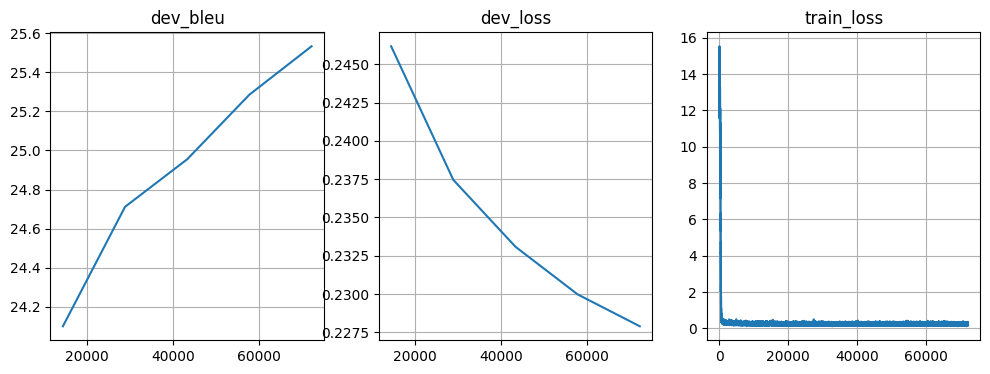

Mean loss=0.218
Best BLEU=25.533


In [22]:
from IPython.display import clear_output
import gc


metrics = {'train_loss': [], 'dev_bleu': [], 'dev_loss': []}  # 'dev_tox_drop': [], 'dev_sim': []}
best_bleu = 0.0
step = 0
accumulate_steps = 4

for _ in tqdm(range(epochs)):
    torch.cuda.empty_cache()
    gc.collect()
    for batch in tqdm(train_loader, leave=False):
        step = len(metrics['train_loss']) + 1
        batch.to(device)
        optimizer.zero_grad()
        model_outputs = model(**batch)
        loss = model_outputs.loss
        loss.backward()
        if step % accumulate_steps == 0:
            optimizer.step()
            scheduler.step()
        metrics['train_loss'].append((step, loss.item()))

    mean_bleu = 0
    mean_loss = 0
    for batch in tqdm(val_loader, leave=False):
        batch.to(device)
        with torch.inference_mode():
            model_output = model(**batch)
            loss = model_output.loss
            pred = model_output.logits.argmax(-1)
            mean_bleu += compute_metrics((pred, batch['labels'],))['bleu']
            mean_loss += loss.item()
    metrics['dev_loss'].append((step, mean_loss / len(val_loader)))
    metrics['dev_bleu'].append((step, 100 * mean_bleu / len(val_loader)))

    if best_bleu < metrics['dev_bleu'][-1][-1]:
        best_bleu = metrics['dev_bleu'][-1][-1]
        model.save_pretrained(model_id) # Will save only LoRA matrices
    
    clear_output(True)
    plt.figure(figsize=(12,4))
    for i, (name, history) in enumerate(sorted(metrics.items())):
        plt.subplot(1, len(metrics), i + 1)
        plt.title(name)
        plt.plot(*zip(*history))
        plt.grid()
    plt.show()
    print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
    print("Best BLEU=%.3f" % best_bleu, flush=True)

## Evaluation on the test set

In [23]:
from peft import PeftConfig, PeftModel

config = PeftConfig.from_pretrained(f'../models/{model_id}')
print(config)

peft_model_id = f'../models/{model_id}'

model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path, device_map={"":0})
model = PeftModel.from_pretrained(model, peft_model_id)

model.eval();

PrefixTuningConfig(peft_type='PREFIX_TUNING', auto_mapping=None, base_model_name_or_path='t5-small', revision=None, task_type='SEQ_2_SEQ_LM', inference_mode=True, num_virtual_tokens=8, token_dim=512, num_transformer_submodules=2, num_attention_heads=8, num_layers=6, encoder_hidden_size=512, prefix_projection=False)


In [25]:
evaluator = Evaluator()
evaluator.similarity_model.to(device)
evaluator.toxicity_model.to(device);

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
toxicity_drop = []
similarity = []

for i, batch in tqdm(enumerate(test_loader), leave=False):
    with torch.no_grad():
        batch.to(device)
        outputs = model.generate(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], do_sample=True, top_p=0.8, max_length=100)
        pred_tokens = tokenizer.batch_decode(outputs.cpu().numpy(), skip_special_tokens=True)
        src_tokens = tokenizer.batch_decode(batch['input_ids'].cpu().numpy(), skip_special_tokens=True)
        if i % 50 == 0:
            print(src_tokens[0])
            print(pred_tokens[0])
            print('-' * 40)
        similarity.extend(evaluator.estimate_similarity(pred_tokens, src_tokens).cpu().numpy().reshape(-1))
        src_toxicity = evaluator.estimate_toxicity(src_tokens, probs=True)
        pred_toxicity = evaluator.estimate_toxicity(pred_tokens, probs=True)
        toxicity_drop.extend((src_toxicity - pred_toxicity).reshape(-1))

0it [00:00, ?it/s]

Smart people's club?
intelligent person club?
----------------------------------------
Flirty, but not too trashy.
dirty, but not too trashy.
----------------------------------------
"I didn't want to do that shit, baby!
"I didn't want to make that shit, baby!
----------------------------------------
Shit, I missed!
Shit, I missed!
----------------------------------------
Her panties. Her head was covered with her panties.
her pigeon was covered with a head of pigeon.
----------------------------------------
Who cares if we all get burned up?
who cares if we're all blown up?
----------------------------------------
How many of you would like to live next to a whorehouse?
how many of you would like to live in a hole?
----------------------------------------
He just thinks I'm full of shit and he's tryin' to flush me out.
he thinks I'm full of shit and he's trying to flush me out.
----------------------------------------
He's the guy who's trying to bury me, for chrissake!
the guy who's 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


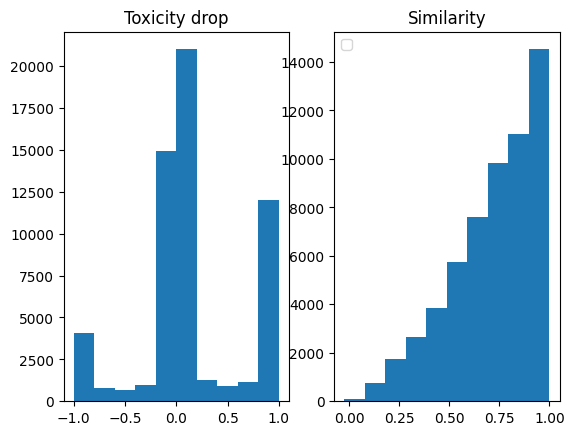

In [28]:
plt.subplot(121)
plt.hist(toxicity_drop)
plt.title('Toxicity drop')
plt.subplot(122)
plt.hist(similarity)
plt.title('Similarity');
plt.legend()
plt.show()

In [29]:
print(np.mean(toxicity_drop), np.std(toxicity_drop))
print(np.mean(similarity), np.std(similarity))

0.14439557 0.51733994
0.7216041 0.21724373


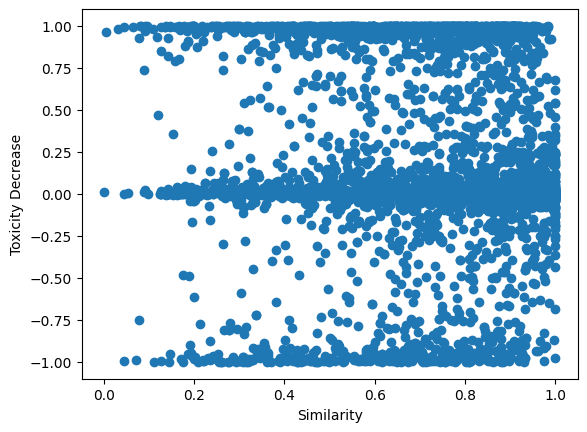

In [30]:
idx = np.random.randint(0, len(similarity), size=int(len(similarity) * 0.1))
plt.scatter(np.array(similarity)[idx], np.array(toxicity_drop)[idx])
plt.xlabel('Similarity') 
plt.ylabel('Toxicity Decrease');